In [38]:
import io

In [42]:
img_crop = ImageGrab.grab([0,0,800,600])

imgByteArr = io.BytesIO()
img_crop.save(imgByteArr, format='PNG')
imgByteArr = imgByteArr.getvalue()

In [43]:
imgByteArr

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\x00\x01\x00\x00IDATx\x9c\xec\xddyXS\xd7\xda7\xe0\x1f(\x82\xc8$\x83\x82E"(\x83C\xb1\xa1\x15g\x82V\xad6\xadb\x8f\x8a-B\xd5:\xbc\x02\xc7\xa3\x16)\xaf\xd6\xb9\xfaR\xb4\xca\xb1\xa8\x9f\x96\xaa\x05iEm\xc5\xb6\xa9\xadC5X\'l\x89\xa2\xa8\x80\x80A**C\x19"\x02\n|\x7f\xec$d&@\xc2\xe4s_\xbd\xceIV\xd6^{egc\x9e<k\xed\xb5\r\xfa9\x0f@c\x8c\x8c\x8c\x8c\x8d\x8d\xbbv5\xeab\xd8\xc5\xb0\x8ba\xa3\xf5\ti+u\xb5u\xb5u\xb5/^<\xaf\xaa\xaaz\xf1\xe2\x85\xeaJ\xf5\xf500\xa8\xaf\x87\x81A\xebv\x8e\x90\xa6\x10\x9f\xa2\xf5\xf50\x00\xa0\xe6d\xa5\x93\x99t\x04/\xe7\xc9\xdc\xb5\xd1\x1a=z\xf405\xed\xd1\n]!\xa4\xe5\x0c\xbb\x18\x1av1422\xea\xde\xdd\xf4i\xe5\xd3\xca\xa7O\xe5^f\xfev\r\x0c\x80\xce\xf37L:+\xf1)j`\x00\xa0\x1e\xf5\x06\n_Kt2\x93\x8e\xe3\xe5<\x99\x1bIG\xf5\xb4\xb2\xa2\xe8\x8atP=L{XY\xf5\x94)\xe8D\xbf\x8c\xc8KF\xf1\x0b\x89Nf\xd2a\xbd<\'\xb3\xa6\x00\xab\x87\xa9iW\xa3n\xad\xd6\x15Bt\xce\xc8\xc8H\xf2\x0b\xa1^m^\x9a\x90\x8e\xa2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as t

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

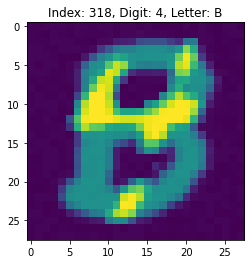

In [4]:
idx = 318
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [6]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [7]:
model = create_cnn_model(x_train)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20)

Train on 2048 samples
Epoch 1/20
  32/2048 [..............................] - ETA: 3:25

InternalError:  cuDNN launch failure : input shape ([32,1,28,28])
	 [[node model/batch_normalization/FusedBatchNormV3 (defined at <ipython-input-7-dd9645505de8>:3) ]] [Op:__inference_distributed_function_2537]

Function call stack:
distributed_function


In [ ]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

In [ ]:
submission.to_csv('baseline.csv', index=False)